<h3 style="text-align: center;">Stock Portfolio Optimization</h3>


This project uses historical stock price data and technical indicators to predict whether a stock will go up the next day. We experiment with two deep learning models:

- **BiLSTM (Bidirectional LSTM)** — captures sequential patterns in stock movements.
- **Transformer Encoder** — uses self-attention to model time-series dependencies.

The pipeline includes preprocessing raw yfinance data, generating technical indicators like RSI and MACD, normalizing the features, training the models, and simulating portfolio returns based on the predictions.


!pip install yfinance ta --quiet



The overall pipeline includes:
- Downloading raw stock data using `yfinance`
- Generating features like RSI and MACD using the `ta` library
- Normalizing the data for better model performance
- Training the models on sequences of past data
- Simulating a trading strategy based on model predictions and evaluating performance

In [57]:
import yfinance as yf
import pandas as pd
import os
import numpy as np
os.makedirs("data", exist_ok=True)

# using Tickers
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META',
           'TSLA', 'NVDA', 'JPM', 'V', 'UNH',
           'PG', 'HD', 'MA', 'DIS', 'PEP',
           'KO', 'BAC', 'INTC', 'PFE', 'CSCO']

# Downlaoding closing prices from 2018 to 2024
data = yf.download(tickers, start="2018-01-01", end="2024-12-31", auto_adjust=True)['Close']

# Drop missing rows
data = data.dropna()
print(data.shape)
data.head()


[*********************100%***********************]  20 of 20 completed

(1760, 20)


Ticker,AAPL,AMZN,BAC,CSCO,DIS,GOOG,HD,INTC,JPM,KO,MA,META,MSFT,NVDA,PEP,PFE,PG,TSLA,UNH,V
Date,,,,,,,,,,,,,,,,,,,,
2018-01-02,40.479832,59.450500,25.191643,30.966265,107.399292,52.998970,157.680344,39.330376,87.571892,36.272209,145.664688,180.568970,79.474159,4.929427,95.272133,25.560184,74.359993,21.368668,198.535263,108.921043
2018-01-03,40.472786,60.209999,25.107395,31.213280,107.860374,53.868851,158.502106,37.995579,87.661118,36.192562,147.496155,183.803726,79.843987,5.253854,95.021973,25.749571,74.269745,21.150000,200.617950,110.005386
2018-01-04,40.660782,60.479500,25.435978,31.301594,107.812355,54.063931,159.760056,37.298801,88.916916,36.702324,149.404327,183.465332,80.546761,5.281549,95.490005,25.805689,74.794739,20.974667,201.488708,110.414398
2018-01-05,41.123718,61.457001,25.553934,31.735125,107.226372,54.851696,161.428818,37.559052,88.346107,36.694359,152.501511,185.973511,81.545395,5.326304,95.764389,25.854792,74.843956,21.105333,205.330872,113.058731
2018-01-08,40.970982,62.343498,25.377005,32.064270,105.689362,55.086086,161.043076,37.559052,88.476593,36.638599,152.962509,187.396790,81.628609,5.489506,95.215630,25.567204,75.237694,22.427334,201.766983,113.515297


### Feature Engineering with Technical Indicators

In this step, we extract useful features from the raw stock price data to help the models learn better.

For each stock:
- We calculate the **daily return** using percentage change.
- We use the `ta` library to compute technical indicators:
  - **RSI (Relative Strength Index)** — measures the speed and change of price movements.
  - **MACD (Moving Average Convergence Divergence)** and its **signal line** — help identify trend direction and momentum.

We rename the columns to include the stock name to avoid confusion when merging.

After generating features for all stocks, we combine them into a single DataFrame and apply **standard normalization** using `StandardScaler` to ensure all features have similar scales before feeding into the models.


In [58]:
import ta #using this to generate indicators like RSI and MACD
from sklearn.preprocessing import StandardScaler

# Store processed features per stock
feature_list = []

for ticker in data.columns:
    df = pd.DataFrame()
    df['price'] = data[ticker]

    # Compute features
    df['return'] = df['price'].pct_change()
    df['rsi'] = ta.momentum.RSIIndicator(df['price']).rsi()
    macd = ta.trend.MACD(df['price'])
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()

    # Renaming colums to avoid collisions
    df.columns = [f"{ticker}_{col}" for col in df.columns]
    feature_list.append(df)

# Combining all stocks
full_df = pd.concat(feature_list, axis=1).dropna()
# Normalize features
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(full_df), columns=full_df.columns, index=full_df.index)

print("Final shape:", scaled_df.shape)
scaled_df.head()



Final shape: (1727, 100)


,AAPL_price,AAPL_return,AAPL_rsi,AAPL_macd,AAPL_macd_signal,AMZN_price,AMZN_return,AMZN_rsi,AMZN_macd,AMZN_macd_signal,...,UNH_price,UNH_return,UNH_rsi,UNH_macd,UNH_macd_signal,V_price,V_return,V_rsi,V_macd,V_macd_signal
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-20,-1.417790,-0.239115,0.084270,-0.395951,-0.598751,-1.492382,0.584701,0.966425,0.511742,0.545444,...,-1.409636,-0.699743,-0.563592,-0.484058,-0.526618,-1.849392,0.036099,0.058156,-0.198628,-0.283982
2018-02-21,-1.420926,-0.300151,-0.024294,-0.359747,-0.554677,-1.473316,0.416589,1.105263,0.544291,0.554073,...,-1.420798,-0.416108,-0.716670,-0.500875,-0.535435,-1.881831,-0.824418,-0.324648,-0.206196,-0.271426
2018-02-22,-1.415178,0.369532,0.136923,-0.320099,-0.510935,-1.470150,0.034537,1.128808,0.564567,0.565336,...,-1.406498,0.449458,-0.480824,-0.485995,-0.539151,-1.882858,-0.068183,-0.336694,-0.214676,-0.263229
2018-02-23,-1.403118,0.838480,0.451891,-0.266123,-0.464395,-1.450966,0.414151,1.273775,0.592291,0.580308,...,-1.384100,0.718958,-0.129994,-0.432188,-0.530057,-1.830503,1.234895,0.227574,-0.148374,-0.242223
2018-02-26,-1.389168,0.962105,0.770264,-0.197921,-0.412572,-1.422244,0.633661,1.479892,0.635831,0.601648,...,-1.355646,0.910815,0.273456,-0.337831,-0.501621,-1.796421,0.771588,0.547471,-0.050048,-0.203991


### Saving Processed Data

In this step, we prepare and save the key datasets needed for model training and analysis.

- `returns_df` is created by calculating the daily percentage change from the raw stock prices.
- We save:
  - `raw_prices.csv`: original stock prices from yfinance
  - `raw_returns.csv`: daily returns for each stock
  - `scaled_features.csv`: normalized technical indicators (like return, RSI, MACD)

These files are saved so we can reuse them without recomputing features every time.


In [59]:
# Recreate returns_df from raw prices
prices_df = data.copy()  # this is from yfinance download
returns_df = prices_df.pct_change().dropna()

# Save raw prices and returns
prices_df.to_csv("data/raw_prices.csv")
returns_df.to_csv("data/raw_returns.csv")

scaled_df.to_csv("data/scaled_features.csv")

print("Saved raw_prices.csv, raw_returns.csv, scaled_features.csv")


Saved raw_prices.csv, raw_returns.csv, scaled_features.csv


### Creating Sequences for Model Training

Here, we convert the processed data into a format suitable for training deep learning models.

- We use a **30-day sliding window** to form input sequences (`X`). Each sequence contains 30 days of technical indicators for all stocks.
- The label (`y`) is created from the **next day's return** for each stock:
  - If the return is positive, the label is `1` (stock goes up)
  - Otherwise, it's `0` (stock goes down)

This forms a **multi-label classification** dataset, where each sample predicts the movement direction for all stocks.

We save the final numpy arrays (`X.npy`, `y.npy`) so we can quickly load them during model training.


In [60]:
sequence_length = 30
X = []
y = []
returns_only = scaled_df[[col for col in scaled_df.columns if col.endswith("_return")]]
for i in range(sequence_length, len(scaled_df) - 1):
    # getting 30-day window of features
    x_seq = scaled_df.iloc[i - sequence_length:i].values
    X.append(x_seq)

    # Direction label for each stock (returns from unscaled data)
    next_day_returns = returns_only.iloc[i + 1]
    direction = (next_day_returns > 0).astype(int).values  # 1 if return > 0 else 0
    y.append(direction)

X = np.array(X)
y = np.array(y)
print("X shape:", X.shape)
print("y shape:", y.shape)
np.save("data/X.npy", X)
np.save("data/y.npy", y)
np.save("data/X_dl_stock.npy", X)
np.save("data/y_dl_stock.npy", y)



X shape: (1696, 30, 100)
y shape: (1696, 20)


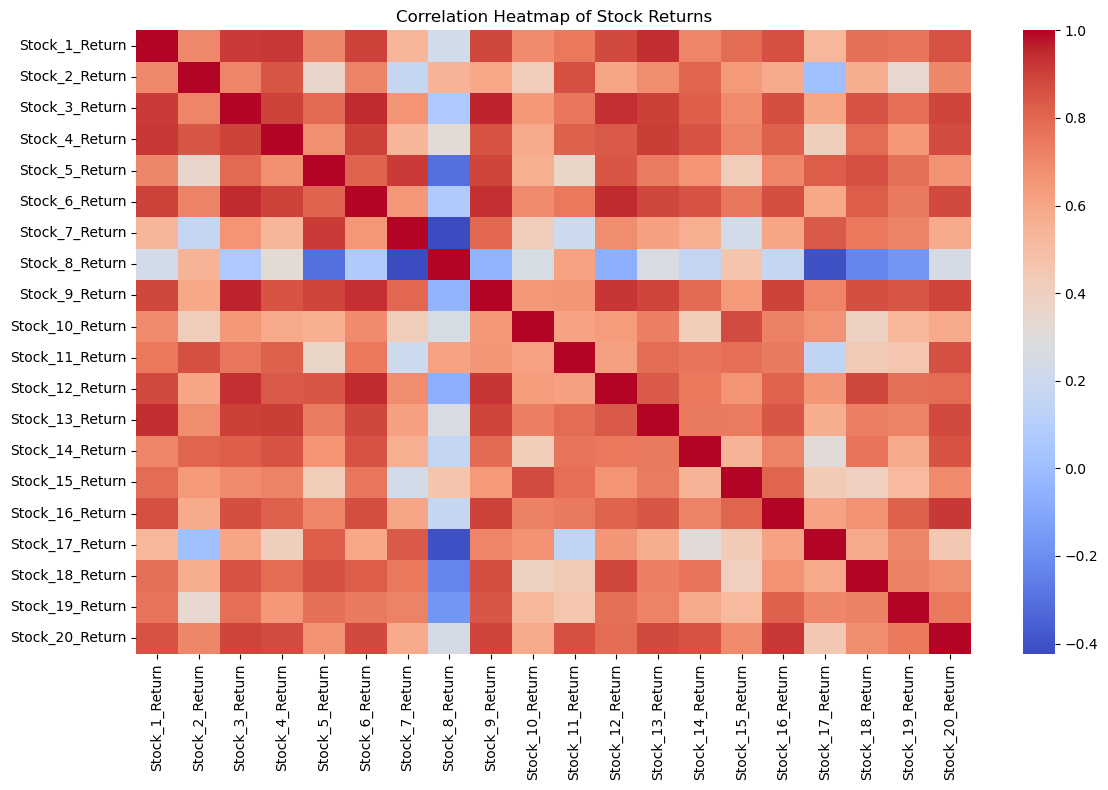

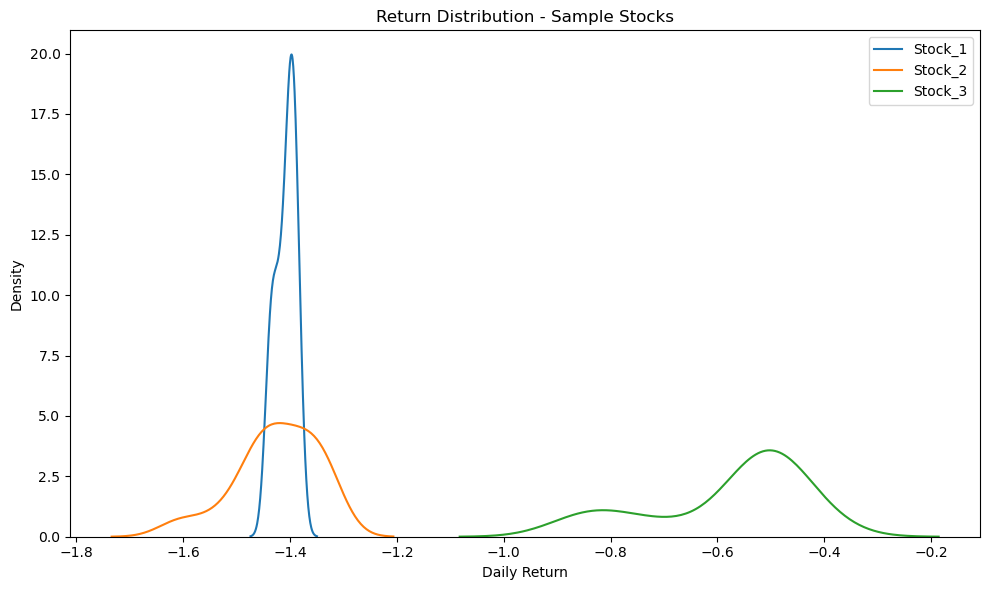

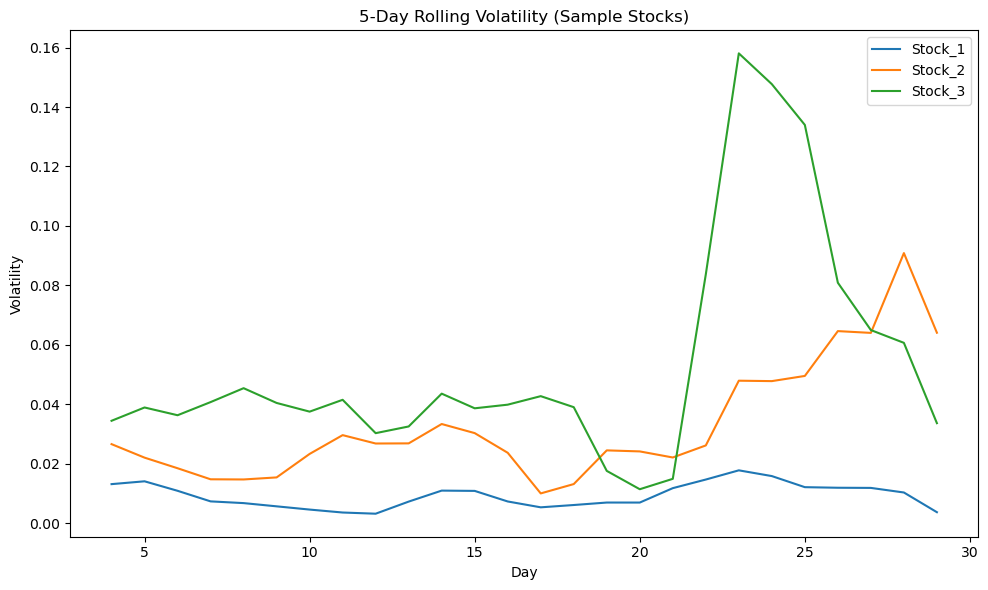

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# load the feature data
X = np.load("data/X_dl_stock.npy")
x = X[0]  # just taking the first sample for plotting (30 days x 100 features)

# setting up column names assuming 20 stocks and 5 features per stock
tickers = [f"Stock_{i+1}" for i in range(20)]
features = ['Return', 'RSI', 'MACD', 'MACD_signal', 'Volume']  # last one is dummy if not used
columns = [f"{stock}_{feat}" for stock in tickers for feat in features]

df = pd.DataFrame(x, columns=columns)

# Plot 1 - Correlation heatmap of just the returns
returns_df = df.loc[:, df.columns.str.contains("Return")]

plt.figure(figsize=(12, 8))
sns.heatmap(returns_df.corr(), cmap='coolwarm')
plt.title("Correlation Heatmap of Stock Returns")
plt.tight_layout()
plt.show()

# Plot 2 - KDE plots for return distributions (first 3 stocks)
plt.figure(figsize=(10, 6))
for i in range(3):
    sns.kdeplot(returns_df.iloc[:, i], label=tickers[i])
plt.title("Return Distribution - Sample Stocks")
plt.xlabel("Daily Return")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# Plot 3 - 5-day rolling volatility for the same 3 stocks
rolling_std_df = pd.DataFrame()
for i in range(3):
    rolling_std_df[tickers[i]] = returns_df.iloc[:, i].rolling(window=5).std()

plt.figure(figsize=(10, 6))
rolling_std_df.plot(ax=plt.gca())
plt.title("5-Day Rolling Volatility (Sample Stocks)")
plt.xlabel("Day")
plt.ylabel("Volatility")
plt.tight_layout()
plt.show()


### Preparing Data for PyTorch Training

We now load the saved `.npy` files and prepare them for training with PyTorch:

- The input (`X`) and labels (`y`) are converted into PyTorch tensors.
- We create a `TensorDataset` to combine inputs and labels.
- The dataset is split into:
  - **80% for training**
  - **20% for validation**

Finally, we use PyTorch `DataLoader` to efficiently load the data in mini-batches during training.


In [61]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split

# Loading datasets
X = np.load("data/X_dl_stock.npy")
y = np.load("data/y_dl_stock.npy")
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

#splitting the Data
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])
#loading the data into dataloaders.
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)


### BiLSTMClassifier Model — Multi-label Stock Direction Prediction

This custom PyTorch model uses a **Bidirectional LSTM** to predict whether each stock in the portfolio will go up tomorrow. Here's how it works:

#### Model Architecture:

- **Input**: A sequence of 30 days of features per stock (e.g., return, RSI, MACD)
- **LSTM Layer**:
  - Learns from the sequential structure of stock data
  - Bidirectional: captures patterns both forward and backward in time
- **Dropout Layer**:
  - Prevents overfitting by randomly deactivating 30% of neurons during training
- **Fully Connected Layer**:
  - Outputs one value (logit) per stock — predicting whether it will go up (1) or not (0)

#### Forward Pass Flow:
1. Input shape: `(batch_size, 30, input_features)`
2. Output from LSTM is a sequence — we take the **last time step's output**
3. Apply dropout for regularization
4. Final output is passed through a `Linear` layer to produce **raw logits** (no activation)
5. We later apply `sigmoid()` during evaluation or use `BCEWithLogitsLoss` during training

This model performs **multi-label classification** — predicting a binary label for **each stock** independently in every sample.


In [63]:
#BiLSTM Multi-label Classifier
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BiLSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # bidirectional = hidden*2

    def forward(self, x):
        out, _ = self.lstm(x)
        last_hidden = out[:, -1, :]  # take last time step
        dropped = self.dropout(last_hidden)
        return self.fc(dropped)  # raw logits


### Training the BiLSTM Model

We initialize and train the `BiLSTMClassifier` model using the following setup:

- **Input size**: Number of features per stock
- **Hidden size**: Number of units in the LSTM layer (64 here)
- **Output size**: One binary output per stock

We use:
- `BCEWithLogitsLoss` as the loss function (suitable for multi-label classification)
- `Adam` optimizer with a learning rate of 0.001

The training loop runs for 20 epochs, where in each epoch:
- We pass batches of sequences through the model
- Compute the loss between predictions and actual labels
- Backpropagate and update model weights

The loss is printed after each epoch to track learning progress.


In [64]:
input_size = X.shape[2]
hidden_size = 64
output_size = y.shape[1]

model = BiLSTMClassifier(input_size, hidden_size, output_size)
loss_fn = nn.BCEWithLogitsLoss()  # for multilabel classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        logits = model(batch_x)
        loss = loss_fn(logits, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} — Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/20 — Loss: 0.6947
Epoch 2/20 — Loss: 0.6894
Epoch 3/20 — Loss: 0.6860
Epoch 4/20 — Loss: 0.6828
Epoch 5/20 — Loss: 0.6787
Epoch 6/20 — Loss: 0.6738
Epoch 7/20 — Loss: 0.6684
Epoch 8/20 — Loss: 0.6633
Epoch 9/20 — Loss: 0.6586
Epoch 10/20 — Loss: 0.6534
Epoch 11/20 — Loss: 0.6488
Epoch 12/20 — Loss: 0.6426
Epoch 13/20 — Loss: 0.6382
Epoch 14/20 — Loss: 0.6326
Epoch 15/20 — Loss: 0.6283
Epoch 16/20 — Loss: 0.6228
Epoch 17/20 — Loss: 0.6189
Epoch 18/20 — Loss: 0.6140
Epoch 19/20 — Loss: 0.6062
Epoch 20/20 — Loss: 0.6040


In [144]:
# save the trained BiLSTM model
torch.save(model.state_dict(), "bilstm_weights.pth")
print("BiLSTM weights saved as 'bilstm_weights.pth'")


BiLSTM weights saved as 'bilstm_weights.pth'


### Evaluating the Model on Validation Data

After training, we evaluate the model's performance on the validation set.

Steps:
- We take the last 20% of the data as the validation set.
- The model makes predictions, and we apply a `sigmoid` to convert logits into probabilities.
- We then threshold the probabilities at 0.5 to get binary predictions (0 or 1).

We calculate multi-label classification metrics using macro averaging:
- **Accuracy**: Overall match between predictions and true labels
- **Precision**: How many predicted positives were correct
- **Recall**: How many actual positives were correctly predicted
- **F1 Score**: Harmonic mean of precision and recall

These metrics help us understand how well the model is predicting across all stocks.


In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Load validation data
val_size = int(0.2 * len(X_tensor))
X_val = X_tensor[-val_size:]
y_val = y_tensor[-val_size:]

# Evaluating the model
model.eval()
with torch.no_grad():
    logits = model(X_val)
    probs = torch.sigmoid(logits)
    y_pred = (probs > 0.5).float().numpy()  # binary predictions
    y_true = y_val.numpy()

# Classification metrics (multi-label average)
accuracy = (y_pred == y_true).mean()
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)

print("Multi-label Classification Metrics:")
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1 Score : {f1:.3f}")


Multi-label Classification Metrics:
Accuracy : 0.683
Precision: 0.675
Recall   : 0.729
F1 Score : 0.699


### Portfolio Simulation Based on Model Predictions

Here, we simulate a basic trading strategy using the model's predicted stock directions:

- We load the **actual next-day returns** (not scaled) for each stock.
- For each day in the validation set:
  - We select the stocks that the model predicted to go up (`y_pred == 1`)
  - We assume we equally invest in all those stocks for that day
  - If no stocks are picked, we assume no investment (0 return)
- The daily return is the average return of the selected stocks.

To make the simulation more realistic, we **clip the daily returns** between -3% and +3%.

We then calculate the following metrics:
- **Cumulative return**: overall growth of the portfolio
- **Sharpe ratio**: return-to-risk ratio
- **Max drawdown**: the biggest drop from peak to lowest point

Finally, we plot how the portfolio value changes over time based on the strategy.



 Portfolio Strategy Based on Classifier:
Total Return      : 428.34%
Sharpe Ratio      : 0.583
Max Drawdown      : 3.00%


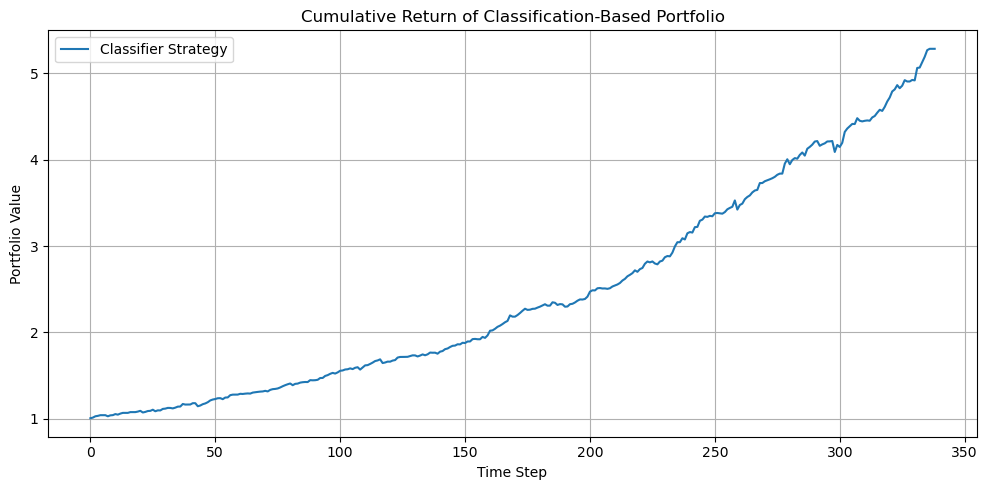

In [67]:
# Loading true next-day returns (not scaled)
returns_df = pd.read_csv("data/raw_returns.csv", index_col=0, parse_dates=True)
returns_df = returns_df[[col.replace('_return', '') for col in returns_only.columns]]
returns_df = returns_df.dropna()

# Aligning  with labels
returns_for_eval = returns_df.iloc[-len(y_pred):].values
# Simulate: invest in all predicted-up stocks each day
daily_returns = []

for i in range(len(y_pred)):
    picks = np.where(y_pred[i] == 1)[0]
    if len(picks) > 0:
        returns = returns_for_eval[i][picks]
        avg_return = np.mean(returns)
    else:
        avg_return = 0  # no investment that day
    daily_returns.append(avg_return)

# Convert to numpy array
daily_returns = np.array(daily_returns)
daily_returns = np.clip(daily_returns, -0.03, 0.03)

# Compute portfolio metrics
cumulative = (1 + daily_returns).cumprod()
rolling_max = np.maximum.accumulate(cumulative)
drawdowns = 1 - cumulative / rolling_max
max_drawdown = drawdowns.max()
total_return = cumulative[-1] - 1
sharpe_ratio = daily_returns.mean() / daily_returns.std()

print("\n Portfolio Strategy Based on Classifier:")
print(f"Total Return      : {total_return*100:.2f}%")
print(f"Sharpe Ratio      : {sharpe_ratio:.3f}")
print(f"Max Drawdown      : {max_drawdown*100:.2f}%")

# Plot cumulative return
plt.figure(figsize=(10, 5))
plt.plot(cumulative, label='Classifier Strategy')
plt.title("Cumulative Return of Classification-Based Portfolio")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Portfolio Simulation with Transaction Costs

To make the strategy more realistic, we now add **transaction costs** to our simulation.

- We assume a cost of `0.1%` per stock traded (`0.001` per transaction).
- On each day, we compare the current picks with the previous day's picks to count how many stocks were changed.
- The total cost for that day is: number of changes × transaction cost.
- We subtract this cost from the average return of the selected stocks.

This simulates the effect of rebalancing the portfolio and helps us understand the **real-world impact of trading frequency**.

As before, we:
- Clip extreme daily returns between -3% and +3%
- Compute cumulative return, Sharpe ratio, and max drawdown
- Plot the overall performance of the strategy with transaction costs applied



 Portfolio Strategy Based on Classifier (Binary Picks + Transaction Cost):
Total Return      : 35.68%
Sharpe Ratio      : 0.106
Max Drawdown      : 7.53%


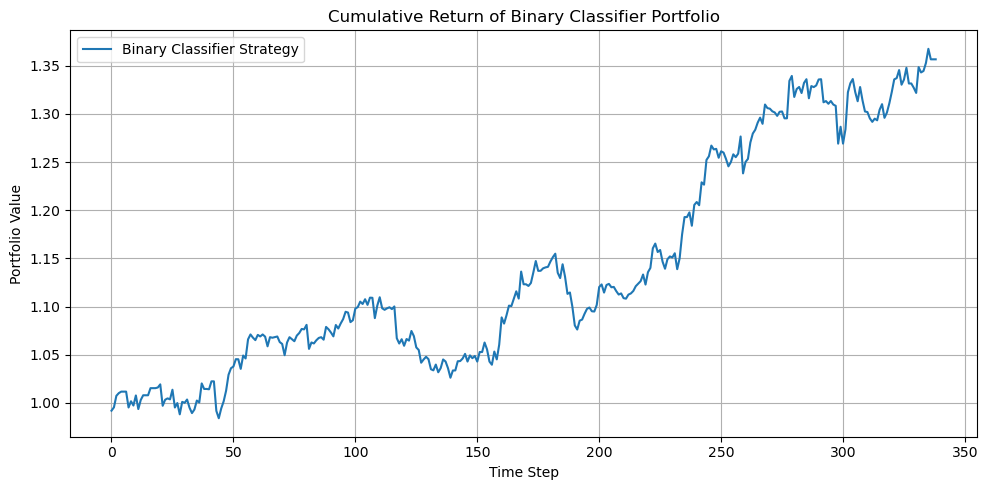

In [68]:

#we are adding transaction cose because these constraints apply in stock market to predict correct results
transaction_cost = 0.001  # 0.1% per stock traded
prev_picks = np.zeros_like(y_pred[0])
daily_returns = []

for i in range(len(y_pred)):
    picks = y_pred[i]
    actual_returns = returns_for_eval[i]

    # Cost: how many stocks changed since yesterday
    changes = np.sum(picks != prev_picks)
    cost = changes * transaction_cost
    prev_picks = picks
    if picks.sum() > 0:
        avg_return = np.mean(actual_returns[picks == 1]) - cost
    else:
        avg_return = 0
    daily_returns.append(avg_return)

# Post-process returns
daily_returns = np.array(daily_returns)
daily_returns = np.clip(daily_returns, -0.03, 0.03)

# Compute metrics
cumulative = (1 + daily_returns).cumprod()
rolling_max = np.maximum.accumulate(cumulative)
drawdowns = 1 - cumulative / rolling_max
max_drawdown = drawdowns.max()
total_return = cumulative[-1] - 1
sharpe_ratio = daily_returns.mean() / daily_returns.std()

# Print results
print("\n Portfolio Strategy Based on Classifier (Binary Picks + Transaction Cost):")
print(f"Total Return      : {total_return*100:.2f}%")
print(f"Sharpe Ratio      : {sharpe_ratio:.3f}")
print(f"Max Drawdown      : {max_drawdown*100:.2f}%")

# Plot performance
plt.figure(figsize=(10, 5))
plt.plot(cumulative, label='Binary Classifier Strategy')
plt.title("Cumulative Return of Binary Classifier Portfolio")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Top-N Confidence-Based Strategy

This strategy selects the top N stocks (here N=3) with the highest predicted confidence scores (from the model's sigmoid outputs) each day.

Steps:
- For each day, we pick the 3 stocks with the highest predicted probabilities.
- We invest equally in those top 3 and calculate the average return for that day.
- We also subtract a transaction cost (0.1% per stock changed compared to the previous day) to simulate real-world trading.

This method helps focus on the **most confident predictions** rather than all predicted positives, which may reduce noise and overtrading.

As before, we:
- Clip extreme returns to ±3%
- Calculate total return, Sharpe ratio, and maximum drawdown
- Plot the cumulative portfolio value over time



 Top-N Confidence-Based Strategy (N=3):
Total Return      : 358.22%
Sharpe Ratio      : 0.431
Max Drawdown      : 3.73%


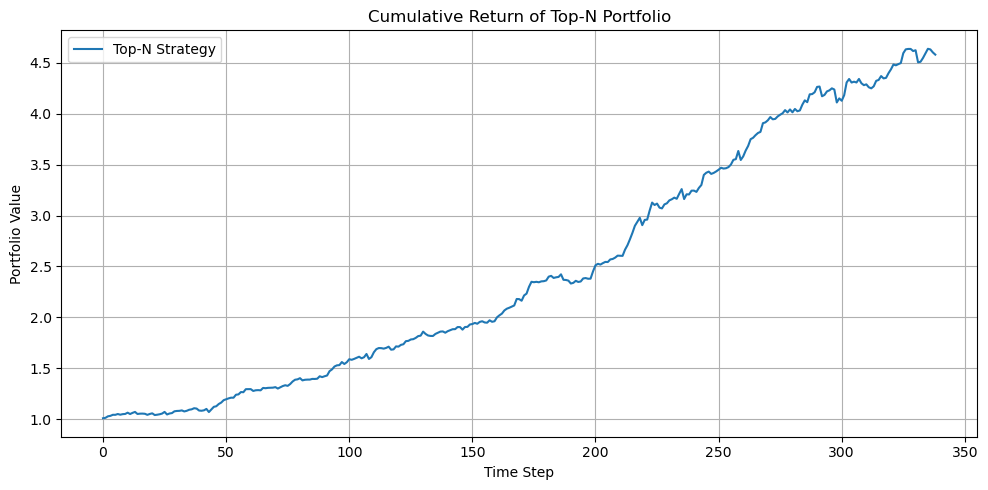

In [69]:
#this is Top-n Strategy.
top_n =3
transaction_cost = 0.001  # 0.1% per stock traded

daily_returns = []
prev_picks = np.zeros(probs.shape[1], dtype=int)

for i in range(len(probs)):
    confidence = probs[i].numpy()
    top_indices = np.argsort(confidence)[-top_n:]  # top-N confident stocks

    picks = np.zeros_like(confidence)
    picks[top_indices] = 1

    actual_returns = returns_for_eval[i]

    # Count how many positions changed
    changes = np.sum(picks != prev_picks)
    cost = changes * transaction_cost
    prev_picks = picks

    if picks.sum() > 0:
        avg_return = np.mean(actual_returns[picks == 1]) - cost
    else:
        avg_return = 0

    daily_returns.append(avg_return)

# Post-process returns
daily_returns = np.array(daily_returns)
daily_returns = np.clip(daily_returns, -0.03, 0.03)

# Compute portfolio metrics
cumulative = (1 + daily_returns).cumprod()
rolling_max = np.maximum.accumulate(cumulative)
drawdowns = 1 - cumulative / rolling_max
max_drawdown = drawdowns.max()
total_return = cumulative[-1] - 1
sharpe_ratio = daily_returns.mean() / daily_returns.std()

# Results
print("\n Top-N Confidence-Based Strategy (N=3):")
print(f"Total Return      : {total_return*100:.2f}%")
print(f"Sharpe Ratio      : {sharpe_ratio:.3f}")
print(f"Max Drawdown      : {max_drawdown*100:.2f}%")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(cumulative, label='Top-N Strategy')
plt.title("Cumulative Return of Top-N Portfolio")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [70]:
# Get the last day's confidence scores
final_probs = probs[-1].numpy()

# Get the Top-N stocks
top_n = 3
top_indices = np.argsort(final_probs)[-top_n:]

# Get corresponding stock names (match order from your data)
stock_names = returns_df.columns.to_list()
recommended_portfolio = [stock_names[i] for i in top_indices]

print(f"Final Day Portfolio Recommendation (Top-{top_n} Stocks):")
for stock in recommended_portfolio:
    print(f"{stock}")


Final Day Portfolio Recommendation (Top-3 Stocks):
UNH
PFE
NVDA


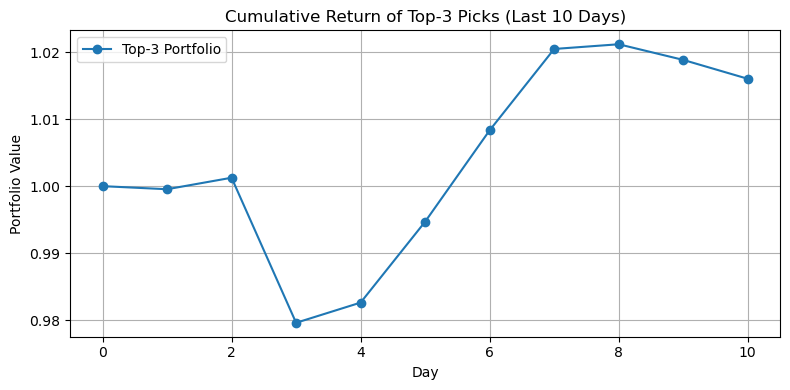

In [71]:
top_n = 3
window = 10
start_day = -window

portfolio_values = [1]  # start with $1

for i in range(start_day, 0):  # last 10 days
    confidence = probs[i].numpy()
    top_indices = np.argsort(confidence)[-top_n:]
    returns = returns_for_eval[i][top_indices]
    avg_return = np.mean(returns)
    new_value = portfolio_values[-1] * (1 + avg_return)
    portfolio_values.append(new_value)

# Plot it
plt.figure(figsize=(8, 4))
plt.plot(range(len(portfolio_values)), portfolio_values, marker='o', label='Top-3 Portfolio')
plt.title("Cumulative Return of Top-3 Picks (Last 10 Days)")
plt.xlabel("Day")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



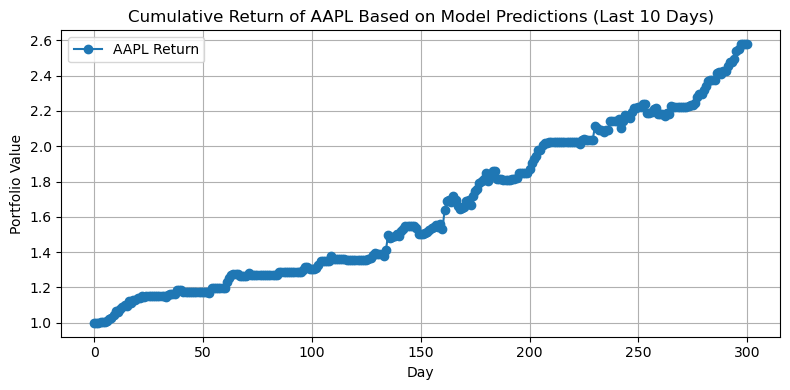

In [72]:
import matplotlib.pyplot as plt

# 1. Find AAPL's index in your stock list
stock_names = returns_df.columns.to_list()
aapl_index = stock_names.index("AAPL")

# 2. Extract confidence and actual returns for AAPL
days = 300
aapl_conf = probs[-days:, aapl_index].numpy()
aapl_returns = returns_for_eval[-days:, aapl_index]

# 3. Binary decision: invest if confidence > 0.5
aapl_picks = (aapl_conf > 0.5).astype(int)

# 4. Compute cumulative return (invest only when predicted up)
cumulative_value = [1]
for pick, ret in zip(aapl_picks, aapl_returns):
    change = ret if pick else 0
    cumulative_value.append(cumulative_value[-1] * (1 + change))

# 5. Plot
plt.figure(figsize=(8, 4))
plt.plot(range(len(cumulative_value)), cumulative_value, marker='o', label='AAPL Return')
plt.title("Cumulative Return of AAPL Based on Model Predictions (Last 10 Days)")
plt.xlabel("Day")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### TransformerEncoderModel for Stock Direction Prediction

This class defines a Transformer-based model for multi-label binary classification. It predicts whether each stock in the portfolio will go up the next day based on past 30-day sequences.

Main components of the model:

- `input_proj`: A linear layer that maps the input features to the hidden dimension expected by the Transformer.
- `positional_encoding`: A learnable embedding that helps the model understand the order of the sequence.
- `encoder`: The actual Transformer encoder made up of multiple layers. It uses self-attention to learn relationships between time steps.
- `dropout`: Used for regularization to reduce overfitting.
- `fc`: A final fully connected layer that gives the output logits (one for each stock).

In the forward pass:
- The input goes through a projection layer.
- Positional encoding is added to help the model know which time step is which.
- The sequence is passed through the Transformer encoder.
- We take the output of the last time step and pass it through dropout and a dense layer.
- The output is a vector of logits (raw scores) for all stocks.


In [74]:
#using transformers
import torch.nn as nn

class TransformerEncoderModel(nn.Module):
    def __init__(self, input_size, seq_len, hidden_dim, output_size, nhead=2, num_layers=2):
        super(TransformerEncoderModel, self).__init__()

        self.input_proj = nn.Linear(input_size, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=nhead,
            dim_feedforward=hidden_dim * 2,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.positional_encoding = nn.Parameter(torch.randn(1, seq_len, hidden_dim))
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        x = self.input_proj(x)
        x = x + self.positional_encoding
        x = self.encoder(x)
        x = x[:, -1, :]  # last timestep
        x = self.dropout(x)
        return self.fc(x)


In [75]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

# Load your prepared dataset
X = np.load("data/X_dl_stock.npy")
y = np.load("data/y_dl_stock.npy")

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Create train/val split
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)


### Training the Transformer Encoder Model

In this section, we train the `TransformerEncoderModel` for multi-label stock direction prediction.

Setup:
- **Input size**: Number of features per time step
- **Sequence length**: Number of time steps (30 days)
- **Hidden dimension**: Size of internal transformer representation (set to 64)
- **Output size**: One binary prediction per stock
- The model uses 2 attention heads and 2 encoder layers.

We use:
- `BCEWithLogitsLoss` for multi-label classification
- `Adam` optimizer with a learning rate of 0.0005

The model is trained for 25 epochs. After training, we save the model parameters to disk for later evaluation and backtesting.


In [76]:
import torch.nn as nn

# Set model hyperparameters
seq_len = X.shape[1]
input_size = X.shape[2]
hidden_dim = 64
output_size = y.shape[1]

# Initialize Transformer
transformer_model = TransformerEncoderModel(
    input_size=input_size,
    seq_len=seq_len,
    hidden_dim=hidden_dim,
    output_size=output_size,
    nhead=2,
    num_layers=2
)

# Define loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.0005)

# Training loop
epochs = 25
for epoch in range(epochs):
    transformer_model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        preds = transformer_model(batch_x)
        loss = loss_fn(preds, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs} — Loss: {total_loss/len(train_loader):.4f}")

# Save the model
torch.save(transformer_model.state_dict(), "models/transformer_classifier.pt")
print("Transformer model trained and saved.")


Epoch 1/25 — Loss: 0.7243
Epoch 2/25 — Loss: 0.7113
Epoch 3/25 — Loss: 0.7040
Epoch 4/25 — Loss: 0.7027
Epoch 5/25 — Loss: 0.6994
Epoch 6/25 — Loss: 0.6954
Epoch 7/25 — Loss: 0.6944
Epoch 8/25 — Loss: 0.6912
Epoch 9/25 — Loss: 0.6884
Epoch 10/25 — Loss: 0.6850
Epoch 11/25 — Loss: 0.6838
Epoch 12/25 — Loss: 0.6812
Epoch 13/25 — Loss: 0.6773
Epoch 14/25 — Loss: 0.6759
Epoch 15/25 — Loss: 0.6701
Epoch 16/25 — Loss: 0.6690
Epoch 17/25 — Loss: 0.6671
Epoch 18/25 — Loss: 0.6588
Epoch 19/25 — Loss: 0.6546
Epoch 20/25 — Loss: 0.6472
Epoch 21/25 — Loss: 0.6458
Epoch 22/25 — Loss: 0.6366
Epoch 23/25 — Loss: 0.6288
Epoch 24/25 — Loss: 0.6201
Epoch 25/25 — Loss: 0.6160
Transformer model trained and saved.


In [77]:
import torch
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Load validation data
val_size = int(0.2 * len(X_tensor))
X_val = X_tensor[-val_size:]
y_val = y_tensor[-val_size:]

# Predict
transformer_model.eval()
with torch.no_grad():
    logits = transformer_model(X_val)
    probs = torch.sigmoid(logits)
    y_pred = (probs > 0.5).float().numpy()
    y_true = y_val.numpy()

# Classification metrics
accuracy = (y_pred == y_true).mean()
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)

print("Transformer Classification Metrics:")
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1 Score : {f1:.3f}")


Transformer Classification Metrics:
Accuracy : 0.627
Precision: 0.612
Recall   : 0.743
F1 Score : 0.670


### Transformer Strategy: Top-3 Confidence-Based Portfolio

This strategy applies the same Top-N logic as before, but now using the confidence scores predicted by the Transformer model.

- For each day, we select the **top 3 stocks** with the highest predicted probability of going up.
- We invest equally in those top 3.
- A **transaction cost** of 0.1% is applied for every stock that changes compared to the previous day.

This strategy focuses on the model's most confident predictions and avoids overtrading.

We calculate:
- **Total return**: how much the portfolio gained overall
- **Sharpe ratio**: reward vs risk
- **Max**



 Transformer Strategy: Top-3 Confidence Picks
Total Return      : 54.43%
Sharpe Ratio      : 0.127
Max Drawdown      : 11.80%


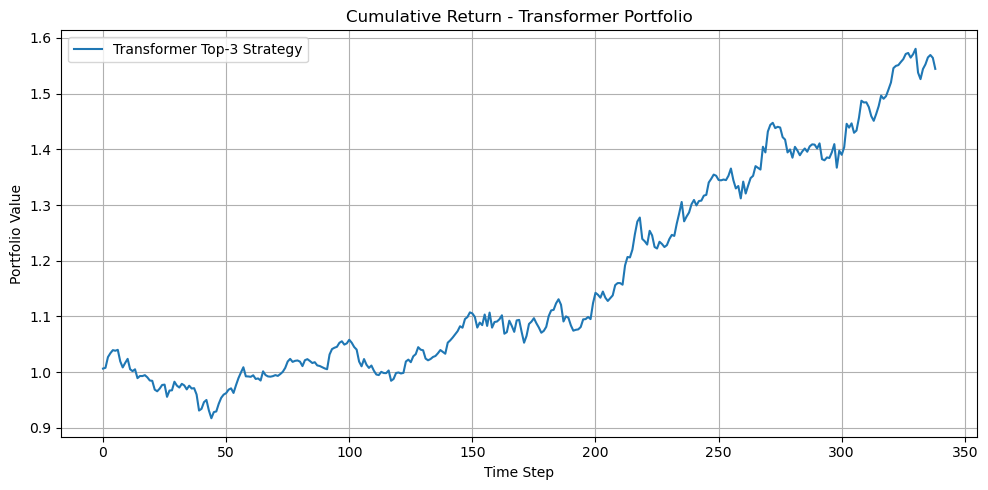

In [78]:

top_n = 3
transaction_cost = 0.001
daily_returns = []
prev_picks = np.zeros(probs.shape[1], dtype=int)

for i in range(len(probs)):
    confidence = probs[i].numpy()
    top_indices = np.argsort(confidence)[-top_n:]

    picks = np.zeros_like(confidence)
    picks[top_indices] = 1

    actual_returns = returns_for_eval[i]
    changes = np.sum(picks != prev_picks)
    cost = changes * transaction_cost
    prev_picks = picks

    if picks.sum() > 0:
        avg_return = np.mean(actual_returns[picks == 1]) - cost
    else:
        avg_return = 0
    daily_returns.append(avg_return)

# Final metrics
daily_returns = np.array(daily_returns)
daily_returns = np.clip(daily_returns, -0.03, 0.03)

cumulative = (1 + daily_returns).cumprod()
rolling_max = np.maximum.accumulate(cumulative)
drawdowns = 1 - cumulative / rolling_max
max_drawdown = drawdowns.max()
total_return = cumulative[-1] - 1
sharpe_ratio = daily_returns.mean() / daily_returns.std()

# Results
print("\n Transformer Strategy: Top-3 Confidence Picks")
print(f"Total Return      : {total_return*100:.2f}%")
print(f"Sharpe Ratio      : {sharpe_ratio:.3f}")
print(f"Max Drawdown      : {max_drawdown*100:.2f}%")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(cumulative, label='Transformer Top-3 Strategy')
plt.title("Cumulative Return - Transformer Portfolio")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Gradio Interface for Stock Forecasting

This section creates an interactive Gradio app to show the model's top 3 stock predictions for the next day.

How it works:
- We take one input sample (`x`) representing the past 30 days of features.
- The model predicts the probability of each stock going up.
- We select the **top 3 stocks** with the highest confidence scores.
- A **summary** is displayed listing the top 3 picks with their confidence levels.
- A **bar chart** is plotted to visualize the confidence of each selected stock.

Gradio makes it easy to build and launch this interface as a simple web app.


In [80]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import gradio as gr
import matplotlib.pyplot as plt

X = np.load("data/X_dl_stock.npy")
x = X[0]  # shape: (30, 100)

# Final Gradio function with bar chart
def stock_forecast_fancy():
    x_tensor = torch.tensor(x[np.newaxis, ...], dtype=torch.float32)

    with torch.no_grad():
        logits = model(x_tensor)
        probs = torch.sigmoid(logits).numpy()[0]

    # Top 3 predictions
    top_3_indices = np.argsort(probs)[-3:][::-1]
    top_3 = [(tickers[i], probs[i]) for i in top_3_indices]

    # Summary text
    summary = "Top 3 stock picks based on model prediction:\n\n"
    for i, (stock, conf) in enumerate(top_3, 1):
        summary += f"{i}. {stock} — {conf:.1%} confidence\n"

    # Bar chart
    fig, ax = plt.subplots(figsize=(6, 4))
    names = [s for s, _ in top_3]
    values = [c for _, c in top_3]
    colors = ['#4c72b0', '#55a868', '#c44e52']

    ax.bar(names, values, color=colors)
    ax.set_ylim(0, 1)
    ax.set_ylabel("Confidence")
    ax.set_title("Model Confidence for Top 3 Predicted Stocks")
    ax.grid(axis='y')

    return summary, fig

# Gradio interface
gr.Interface(
    fn=stock_forecast_fancy,
    inputs=[],
    outputs=["text", "plot"],
    title="Top 3 Stock Predictions",
    description="This bar chart shows the model's confidence in its top 3 predicted stocks for tomorrow."
).launch(share = "True")

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://a6392068510d8be71c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
